<a href="https://colab.research.google.com/github/AlvielD/unibo_dl_2223/blob/main/lab_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab lesson 2 - CNN & Transfer learning

## Libraries and configuration

In [17]:
# General libraries
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

# Specific model layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Input,
    Rescaling,
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Dropout,
    RandomFlip,
    RandomRotation,
    RandomZoom
)

# Some libraries for the training
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping

# Image displaying library
import PIL

## Load data

In [2]:
# Download the data from the link
!wget https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz

--2023-04-03 07:57:43--  https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.218.128, 142.251.31.128, 142.250.153.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.218.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228813984 (218M) [application/x-compressed-tar]
Saving to: ‘flower_photos.tgz’

flower_photos.tgz   100%[===================>] 218.21M  39.1MB/s    in 6.3s    

2023-04-03 07:57:49 (34.5 MB/s) - ‘flower_photos.tgz’ saved [228813984/228813984]



In [3]:
# Decompress the tgz file
!tar -xf flower_photos.tgz

In [4]:
# Now we have the path to the file
file_path = "/content/flower_photos"

d = 180         # Image size
rand_seed = 43  # Random state 

# Load data into memory from the directory
data = tf.keras.utils.image_dataset_from_directory(
    file_path,
    image_size=(d,d),
    seed=rand_seed,
    validation_split=0.2,   # Proportion of the validation set
    subset='both'           # Specify that we want both, train and validation splits
)

# Extract the two splits from the dataset object
train_data, val_data = data

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Using 734 files for validation.


In [5]:
class_names = train_data.class_names
print(class_names)
n_classes = len(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


Notice we are setting the image size to the $d$ variable. This is not recommended, but we do it to speed up the learning (since this is just a laboratory).

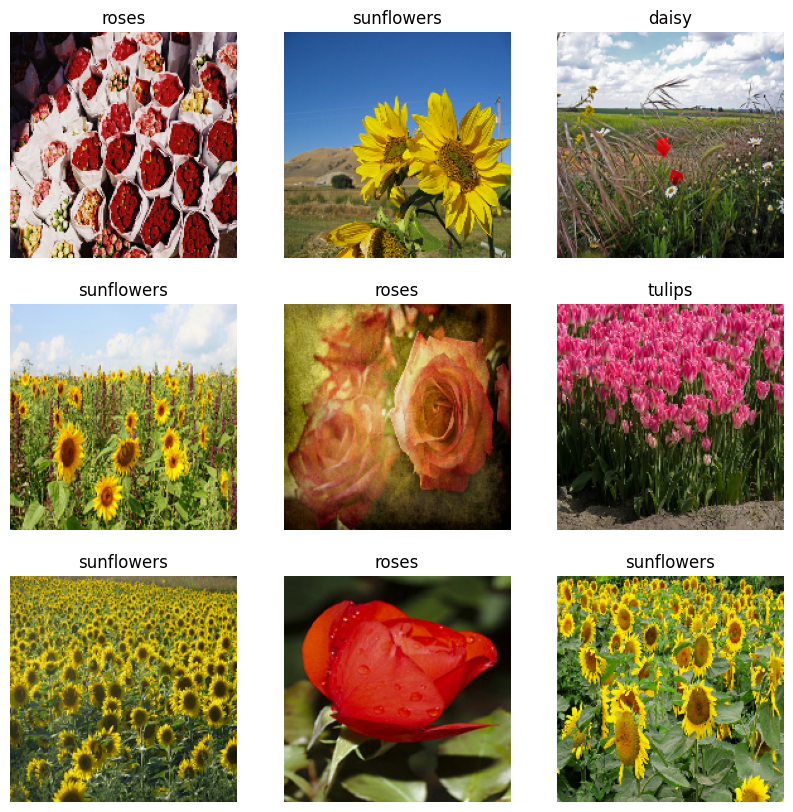

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Model

In [ ]:
"""
Function that creates our model for the IP task
"""
def create_model(in_shape, out_shape):

  # Define the architecture of the model
  input = Input(shape=in_shape) # Input layer
  r = Rescaling(1./255)(input)  # Rescaling layer

  # Define a 2D convolution layer (features extraction)
  conv_1 = Conv2D(
      filters=16,       # Dimensionality of the output space
      kernel_size=3,    # Kernel size (3x3)
      padding="same",   # Type of padding (same = zero-padding)
      activation="relu")(r)

  p1 = MaxPooling2D((2,2))(conv_1)  # Pooling layer (gathers all the information of the previous layer)
  
  # With few layers the dropout is not effective (read theory to understand)
  #dropout = Dropout(0.4)(p1)                     # Avoid overfitting
  
  f = Flatten()(p1)                         # Flatten layer
  d = Dense(out_shape, activation='softmax')(f)  # Output layer

  # Now create the model
  model = Model(input, d)
  model.summary()

  return model

In [ ]:
model = create_model(in_shape=(d, d, 3), out_shape=5)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 90, 90, 16)        0         
                                                                 
 flatten_2 (Flatten)         (None, 129600)            0         
                                                           

In [ ]:
# Compile model
model.compile(
    optimizer=Adam(1e-3),
    metrics=['accuracy'],
    loss = SparseCategoricalCrossentropy(from_logits=True)
)

# Fit the data
history = model.fit(train_data, epochs=10, validation_data=val_data)

Epoch 1/10
92/92 [==============================] - 6s 58ms/step - loss: 1.7083 - accuracy: 0.4571 - val_loss: 1.1712 - val_accuracy: 0.4877
Epoch 2/10
92/92 [==============================] - 6s 56ms/step - loss: 0.9607 - accuracy: 0.6345 - val_loss: 1.1238 - val_accuracy: 0.5395
Epoch 3/10
92/92 [==============================] - 7s 64ms/step - loss: 0.7319 - accuracy: 0.7537 - val_loss: 1.1496 - val_accuracy: 0.5599
Epoch 4/10
92/92 [==============================] - 7s 69ms/step - loss: 0.4996 - accuracy: 0.8501 - val_loss: 1.1128 - val_accuracy: 0.5749
Epoch 5/10
92/92 [==============================] - 5s 56ms/step - loss: 0.3308 - accuracy: 0.9196 - val_loss: 1.1427 - val_accuracy: 0.5531
Epoch 6/10
92/92 [==============================] - 6s 58ms/step - loss: 0.2399 - accuracy: 0.9510 - val_loss: 1.1348 - val_accuracy: 0.5681
Epoch 7/10
92/92 [==============================] - 7s 69ms/step - loss: 0.1636 - accuracy: 0.9748 - val_loss: 1.2753 - val_accuracy: 0.5327
Epoch 8/10
92

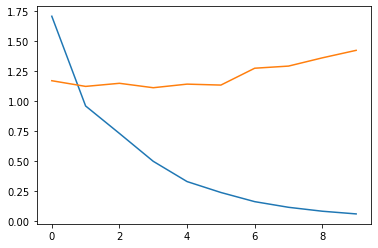

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [ ]:
data_aug_model = Sequential()

## Elimination of Overfitting

### 1. Data augmentation
One of the reasons for overfitting is the lack of data. For this reason we use the so known "data augmentation" techniques to simulate a bigger amount of data than the one we actually have.

In [14]:
data_augmentation = lambda input_shape: tf.keras.Sequential([
    RandomFlip("horizontal", input_shape=input_shape),
    RandomRotation(0.1),
    RandomZoom(0.1),
])

We create another model that performs random flips, rotation and zooms. This will make the model believe we have different images when we are just performing some transformations on the same image.

### 2. Dropout
This will drop out some of the neurons on the targeted layer, reducing its learning.
(If we have really low amount of layers this won't have a positive impact)

In [15]:
def create_drop_model(input_shape, num_classes):

    x = Input(shape=input_shape)                    # Input layer
    augmented = (data_augmentation(input_shape))(x) # Data augmentation model
    r = Rescaling(1./255)(augmented)                # Reescaling layer

    # Convolutional + Pooling layers
    c1 = Conv2D(16, 3, padding='same', activation='relu')(r)
    p1 = MaxPooling2D((2, 2))(c1)
    c2 = Conv2D(32, 3, padding='same', activation='relu')(p1)
    p2 = MaxPooling2D((2, 2))(c2)
    c3 = Conv2D(64, 3, padding='same', activation='relu')(p2)
    p3 = MaxPooling2D((2, 2))(c3)

    d = Dropout(.2)(p3) # Drops out the previous layer
    f = Flatten()(d)    # Flattens information

    # Dense layers for inferetation
    d1 = Dense(128, activation='relu')(f)
    d2 = Dense(num_classes)(d1)

    model = Model(x, d2)  # Instantiates the model
    model.summary()       # Prints summary
    
    return model

model = create_drop_model((d, d, 3), n_classes)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                             

### 3. EarlyStopping
This technique focus on stopping the learning process when the model arrives to the inflextion point where it starts to overfit.

In [18]:
# We implement earlyStopping as a callback for our model
callback = EarlyStopping(monitor="val_accuracy",
                         mode="max",
                         patience=5,
                         restore_best_weights=True)

model.compile(optimizer=Adam(learning_rate=1e-3),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(train_data, epochs=15, validation_data=val_data, callbacks=[callback])

Epoch 1/15
92/92 [==============================] - 20s 86ms/step - loss: 1.2407 - accuracy: 0.4656 - val_loss: 1.2331 - val_accuracy: 0.5123
Epoch 2/15
92/92 [==============================] - 6s 62ms/step - loss: 1.0106 - accuracy: 0.6012 - val_loss: 1.0668 - val_accuracy: 0.5899
Epoch 3/15
92/92 [==============================] - 7s 76ms/step - loss: 0.8893 - accuracy: 0.6495 - val_loss: 1.0511 - val_accuracy: 0.6199
Epoch 4/15
92/92 [==============================] - 6s 62ms/step - loss: 0.8391 - accuracy: 0.6768 - val_loss: 0.8751 - val_accuracy: 0.6853
Epoch 5/15
92/92 [==============================] - 7s 76ms/step - loss: 0.7573 - accuracy: 0.7112 - val_loss: 0.8183 - val_accuracy: 0.6839
Epoch 6/15
92/92 [==============================] - 7s 75ms/step - loss: 0.7444 - accuracy: 0.7129 - val_loss: 0.8292 - val_accuracy: 0.6866
Epoch 7/15
92/92 [==============================] - 6s 62ms/step - loss: 0.7174 - accuracy: 0.7204 - val_loss: 0.8473 - val_accuracy: 0.6866
Epoch 8/15
9

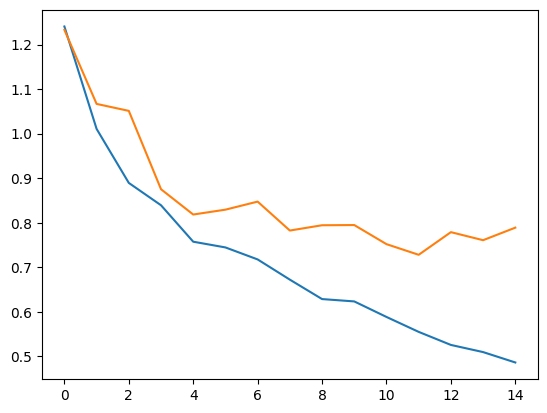

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()